In [1]:
import numpy as np
from pandas import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier

import time

In [2]:
data = pd.read_csv("tomorrows_value_final.csv", engine='python')
data.head()

,Unnamed: 0,icustay_id,mergeID,label,creatinine_tomorrow,creatinine_yesterday,creatinine_before_yesterday,arterial_pressure_systolic,arterial_pressure_systolic_delay,arterial_pressure_systolic_time,...,total_protein_urine_time,bilirubin,bilirubin_delay,bilirubin_time,c_reactive_protein,c_reactive_protein_delay,c_reactive_protein_time,ethnicity,diagnosis,gender
0,1,200001,200001 2181-11-26 05:36:00,0,3.5,NaN,NaN,NaN,NaN,NaN,...,NaN,0.2,0.0,2181-11-26 05:36:00,NaN,NaN,NaN,ASIAN - ASIAN INDIAN,ALTERED MENTAL STATUS,F
1,2,200001,200001 2181-11-27 05:54:00,1,2.9,2.7,NaN,NaN,NaN,NaN,...,NaN,0.2,87480.0,2181-11-26 05:36:00,NaN,NaN,NaN,ASIAN - ASIAN INDIAN,ALTERED MENTAL STATUS,F
2,3,200003,200003 2199-08-03 01:47:00,1,0.7,NaN,NaN,NaN,NaN,NaN,...,NaN,3.4,0.0,2199-08-03 01:47:00,NaN,NaN,NaN,WHITE,S/P RESECTION,M
3,4,200003,200003 2199-08-04 01:21:00,2,0.8,1.0,NaN,NaN,NaN,NaN,...,NaN,3.9,27840.0,2199-08-03 17:37:00,NaN,NaN,NaN,WHITE,S/P RESECTION,M
4,5,200003,200003 2199-08-05 02:25:00,2,0.7,0.7,1.0,NaN,NaN,NaN,...,NaN,4.7,0.0,2199-08-05 02:25:00,NaN,NaN,NaN,WHITE,S/P RESECTION,M


In [3]:
data.shape

(143048, 122)

In [4]:
def keep(col):
    
    if ('label' in col) or ('Unnamed' in col) or ("_id" in col) or (".y" in col) or ("ID" in col) or ("time" in col) or ("creatinine_tomorrow" in col):
        return False
    return True
    
kept_feature = [ col for col in data.columns.values if keep(col)]
print(kept_feature)


['creatinine_yesterday', 'creatinine_before_yesterday', 'arterial_pressure_systolic', 'arterial_pressure_systolic_delay', 'arterial_pressure_diastolic', 'arterial_pressure_diastolic_delay', 'heart_rate', 'heart_rate_delay', 'weight_daily', 'weight_daily_delay', 'temperature', 'temperature_delay', 'urine_output', 'urine_output_delay', 'day_urine_output', 'day_urine_output_delay', 'creatinine', 'age', 'scr', 'scr_delay', 'urea', 'urea_delay', 'sodium', 'sodium_delay', 'potassium', 'potassium_delay', 'calcium', 'calcium_delay', 'phosphor', 'phosphor_delay', 'leukocytes', 'leukocytes_delay', 'hemoglobine', 'hemoglobine_delay', 'bicarbonate', 'bicarbonate_delay', 'lactate', 'lactate_delay', 'uric_acid', 'uric_acid_delay', 'chloride', 'chloride_delay', 'neutrophils', 'neutrophils_delay', 'lymphocytes', 'lymphocytes_delay', 'platelet_count', 'platelet_count_delay', 'ph_blood', 'ph_blood_delay', 'ph_urine', 'ph_urine_delay', 'monocytes', 'monocytes_delay', 'fibrinogen', 'fibrinogen_delay', 'ur

In [5]:
#feat_names = ['creatinine_yesterday', 'creatinine_before_yesterday',
#              'urea', 'potassium', 'calcium',
#              'phosphor', 'lactate', 'platelet_count', 'ph_blood',
#              'creatinine.x', 'age.x', 'alkaline_phospatase', 'albumin','bilirubin
              
feat_names = kept_feature              

#for name in feat_names:
#    print(name, ' max: ', data[name].max())
#    print(name, ' median: ', data[name].median())
#    print(name, ' min: ', data[name].min(),'\n')

data = data[data['creatinine'] < 20]
data = data[data['creatinine_yesterday'] < 20]
data = data[data['creatinine_before_yesterday'] < 20]
data = data[data['bilirubin'] < 20]


In [6]:
data.shape

(65527, 122)

## Model selection part

In [7]:

X = data[feat_names]

X.dropna(axis=1, how="all", inplace=True)

y = data['label']

y[y == 2] = 1

X.shape, y.shape

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


((65527, 63), (65527,))

In [8]:
X = pd.concat(( X.drop(['gender'], axis=1), pd.get_dummies(X['gender'])), axis=1)
X = pd.concat(( X.drop(['ethnicity'], axis=1), pd.get_dummies(X['ethnicity'])), axis=1)

In [9]:
X.shape, y.shape

((65527, 99), (65527,))

In [10]:
diag = X['diagnosis']

X.loc[diag == "FEVER",'diagnosis'] = "SEPSIS"
X.loc[(diag == "DYSPNEA") & (diag == "SHORTNESS OF BREATH"),'diagnosis'] = "RESPIRATORY FAILURE"

X.loc[
    (diag != 'PNEUMONIA') & (diag != "SEPSIS") & (diag != "CONGESTIVE HEART FAILURE") &
    (diag != "SUBARACHNOID HEMORRHAGE") & (diag != "INTRACRANIAL HEMORRHAGE") & 
    (diag != "ALTERED MENTAL STATUS") & (diag != "CORONARY ARTERY DISEASE") & (diag != "ABDOMINAL PAIN") &
    (diag != "CHEST PAIN") & (diag != "HYPOTENSION") & (diag != "ACUTE RENAL FAILURE") &
    (diag != "RESPIRATORY FAILURE") & (diag != "GASTROINTESTINAL BLEED") & (diag != "PANCREATITIS"), 'diagnosis'
] = "OTHER_DIAG"

In [11]:
X.shape, y.shape

((65527, 99), (65527,))

In [12]:
X = pd.concat(( X.drop(['diagnosis'], axis=1), pd.get_dummies(X['diagnosis'])), axis=1)

In [13]:
X.columns.values, X.shape, y.shape

(array(['creatinine_yesterday', 'creatinine_before_yesterday', 'creatinine',
        'age', 'scr', 'scr_delay', 'urea', 'urea_delay', 'sodium',
        'sodium_delay', 'potassium', 'potassium_delay', 'calcium',
        'calcium_delay', 'phosphor', 'phosphor_delay', 'leukocytes',
        'leukocytes_delay', 'hemoglobine', 'hemoglobine_delay',
        'bicarbonate', 'bicarbonate_delay', 'lactate', 'lactate_delay',
        'uric_acid', 'uric_acid_delay', 'chloride', 'chloride_delay',
        'neutrophils', 'neutrophils_delay', 'lymphocytes',
        'lymphocytes_delay', 'platelet_count', 'platelet_count_delay',
        'ph_blood', 'ph_blood_delay', 'ph_urine', 'ph_urine_delay',
        'fibrinogen', 'fibrinogen_delay', 'urinary_sodium',
        'urinary_sodium_delay', 'urinary_potassium',
        'urinary_potassium_delay', 'urine_urea', 'urine_urea_delay',
        'urine_creatinin', 'urine_creatinin_delay', 'alkaline_phospatase',
        'alkaline_phospatase_delay', 'total_protein_blood',

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Split to three test sets
test_size = len(X_test) // 3

X_test1 = X_test[0:2 * test_size]
y_test1 = y_test[0:2 * test_size]

X_test2 = X_test[2*test_size:]
y_test2 = y_test[2*test_size:]

### Train a XGBoost model with hyperparameters optim

##### Train a non-NN classifier on all features

In [23]:
baseline = XGBClassifier(
        n_thread=4,
        eval_metric='logloss',                
        learning_rate='0.03',
        max_depth=9,
        max_delta_step=10
    )


In [24]:
baseline.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='logloss', gamma=0,
       learning_rate='0.03', max_delta_step=10, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       n_thread=4, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [26]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

In [33]:
%matplotlib notebook

In [35]:
print(baseline.feature_importances_)

[  4.60387692e-02   3.07627469e-02   4.68815863e-02   2.60921475e-02
   0.00000000e+00   0.00000000e+00   3.17109153e-02   1.05351872e-04
   1.07458914e-02   2.20185425e-02   1.89633369e-02   2.82694194e-02
   2.57409755e-02   3.37477177e-02   2.87961792e-02   3.58196371e-03
   9.48166882e-04   2.38797581e-03   1.67860650e-02   2.47576907e-02
   2.24750675e-03   7.23416219e-03   2.30018254e-02   3.49417068e-02
   5.47829736e-03   7.86627363e-03   1.19398795e-02   1.80854052e-02
   2.39148755e-02   2.47576907e-02   2.24048328e-02   0.00000000e+00
   3.00252847e-02   1.43980898e-03   3.03764567e-02   2.80587170e-02
   3.16055637e-04   8.07697710e-04   2.10001413e-02   2.61623822e-02
   1.36606265e-02   1.76991150e-02   6.67228550e-03   1.18696447e-02
   1.15887066e-02   1.23612871e-02   1.53462561e-02   1.89984553e-02
   3.28697860e-02   1.65753625e-02   2.87961797e-03   5.23247663e-03
   2.78128944e-02   2.68998463e-02   4.77595162e-03   3.37125990e-03
   2.88312957e-02   7.44486600e-03

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<IPython.core.display.Javascript object>


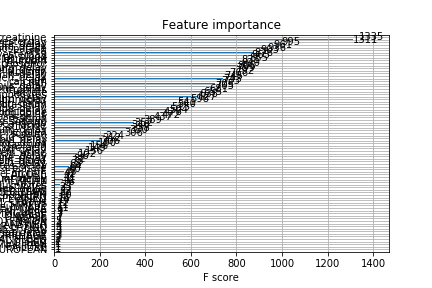

[0.046881586, 0.046038769, 0.034941707, 0.033747718, 0.032869786, 0.031710915, 0.030762747, 0.030376457, 0.030025285, 0.028831296, 0.028796179, 0.028269419, 0.028058717, 0.027812894, 0.026899846, 0.026162382, 0.026092147, 0.025740976, 0.024757691, 0.024757691, 0.023914875, 0.023001825, 0.022404833, 0.022018543, 0.021000141, 0.018998455, 0.018963337, 0.018085405, 0.017699115, 0.016786065, 0.016575363, 0.015346256, 0.013660626, 0.012361287, 0.01193988, 0.011869645, 0.011588707, 0.010745891, 0.0078662736, 0.007444866, 0.0072341622, 0.0066722855, 0.0054782974, 0.0052324766, 0.0047759516, 0.0035819637, 0.0033712599, 0.002879618, 0.0025635622, 0.0023879758, 0.0022475068, 0.0021070375, 0.0015802782, 0.0014749262, 0.001439809, 0.001439809, 0.0012642225, 0.00094816688, 0.00080769771, 0.00077258045, 0.00077258045, 0.00070234586, 0.00056187669, 0.0004916421, 0.00042140749, 0.00038629022, 0.00038629022, 0.00031605564, 0.00024582105, 0.00024582105, 0.00024582105, 0.00017558647, 0.00014046917, 0.000

In [37]:
plot_importance(baseline)

print(sorted(baseline.feature_importances_, reverse=True))

plt.show()

In [42]:
len(X)

65527

In [40]:
len(X.columns.values)

113

In [25]:
%load_ext autoreload
%autoreload 2
from sklearn.metrics import fbeta_score, accuracy_score, confusion_matrix

def compute_metrics(y_real, predictions ):

    conf = confusion_matrix(y_real, predictions)


    return conf
    
y_pred = baseline.predict(X_test1)

print(y_pred[:20])
metrics = compute_metrics(y_test1, y_pred)
print(metrics)

#0 Increase
#1 Decrease
#2 stable

precision_increase = metrics[0, 0] / sum(metrics[:, 0])
sensibility_increase = metrics[0, 0] / sum(metrics[0, :])


#specifity_decrease = (metrics[0, 0] + metrics[2, 0] + metrics[0, 2] + metrics[2, 2] ) / (metrics[0, :] + metrics[2, :])
print(precision_increase, sensibility_increase)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
[[ 242 1154]
 [ 122 7218]]
0.664835164835 0.17335243553


In [ ]:

from sklearn.ensemble import AdaBoostClassifier
from pprint import pprint

def hyp_tuning(X_train, X_test, y_train, y_test):
    # Initialize the classifier
    #clf = AdaBoostClassifier(RandomForestClassifier(class_weight="balanced"), random_state = 42)

    clf = XGBClassifier(
        n_thread=4,
        eval_metric='mlogloss',
        num_class= 3,
        objective= 'multi:softmax'
    )
    
    # Create cross-validation sets from the training data
    cv_sets = StratifiedShuffleSplit(n_splits=3, test_size=0.1, train_size=None, random_state=42)

    # Create the parameters list you wish to tune
    parameters = {
                        
#        'num_boost_round': [100, 250],
        'learning_rate': [0.05, 0.15],        
        'max_depth': [6, 9, 12],
        #'subsample': [0.9, 1.0],
        #'colsample_bytree': [0.9, 1.0],
    }
    
    
    
    # Make an fbeta_score scoring object
    scorer = make_scorer(fbeta_score, beta = 0.5, average = 'weighted')

    # Perform grid search on the classifier using 'scorer' as the scoring method
    grid_obj = GridSearchCV(clf, param_grid = parameters, scoring = scorer, cv = cv_sets, verbose=10)

    # Fit the grid search object to the training data and find the optimal parameters
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    best_predictions = best_clf.predict(X_test)
    return best_clf, best_predictions

# Report the before-and-afterscores
start = time.time()

best_clf, best_predictions = hyp_tuning(X_train, X_test1, y_train, y_test1)

end = time.time()
print("Time elapsed: ", (end - start)/60, " min")

conf = confusion_matrix(y_test1, best_predictions)
sensitivity_A = conf[0][0]/(sum(conf[0][:])) # (TP/(TP+FN))
specificity_B = (conf[0][1] + conf[2][1])/(conf[1][0] + conf[1][2] + conf[0][1] + conf[2][1]) # TN/(FP+TN)
print("Confusion matrix")
pprint(confusion_matrix(y_test1, best_predictions))
# print("Sensitivity for class A is: ", sensitivity_A)
# print("Specificity for class B is: ", specificity_B)

print("\nClassification report")
print(classification_report(y_test1, best_predictions))

## Feature selection part

In [ ]:
import re
from itertools import combinations
# import warnings
# warnings.filterwarnings("ignore")

X_train.append(X_test1)
y_train.append(y_test1)


for i in range(3, len(list(feat_names)) - 1):
    combs_obj = combinations(list(feat_names), i)

    for combination in combs_obj:
        combination = list(combination)
        print(combination)

        cols_to_drop = combination #re.sub(''.join(combination), '', feat_names)
        temp_train = X_train
        temp_test = X_test2
        X_train = X_train.drop(list(cols_to_drop), axis=1)
        X_test2 = X_test2.drop(list(cols_to_drop), axis=1)

        # This try/except throws a strange error for some feature combinations. Probably it won't be 
        # necessary with the real data
        try:
            best_clf, best_predictions = hyp_tuning(X_train, X_test2, y_train, y_test2)
            conf = confusion_matrix(y_test2, best_predictions)
            sensitivity_A = conf[0][0]/(sum(conf[0][:])) # (TP/(TP+FN))
            specificity_B = (conf[0][1] + conf[2][1])/(conf[1][0] + conf[1][2] + conf[0][1] + conf[2][1]) # TN/(FP+TN)
            print("Confusion matrix")
            pprint(confusion_matrix(y_test1, best_predictions))
#             print("Sensitivity for class A is: ", sensitivity_A)
#             print("Specificity for class B is: ", specificity_B)
            
            print("\nClassification report")
            print(classification_report(y_test1, best_predictions))
        except:
            print('Could not train')
        
        X_train = temp_train
        X_test2 = temp_test

##### Define and re-train set of best features

In [ ]:
cols_to_drop = []

temp_train = X_train
temp_test = X_test2
X_train = X_train.drop(list(cols_to_drop), axis=1)
X_test2 = X_test2.drop(list(cols_to_drop), axis=1)

best_clf, best_predictions = hyp_tuning(X_train, X_test2, y_train, y_test2)
conf = confusion_matrix(y_test2, best_predictions)
sensitivity_A = conf[0][0]/(sum(conf[0][:])) # (TP/(TP+FN))
specificity_B = (conf[0][1] + conf[2][1])/(conf[1][0] + conf[1][2] + conf[0][1] + conf[2][1]) # TN/(FP+TN)
print("Confusion matrix")
pprint(confusion_matrix(y_test1, best_predictions))
print("Sensitivity for class A is: ", sensitivity_A)
print("Specificity for class B is: ", specificity_B)


print("Classification report")
print(classification_report(y_test1, best_predictions))

X_train = temp_train
X_test2 = temp_test

## Checking for overfitting

In [ ]:
X_train.append(X_test2)
y_train.append(y_test2)

X_train = X_train.drop(list(cols_to_drop), axis=1)
X_test3 = X_test3.drop(list(cols_to_drop), axis=1)

best_clf, best_predictions = hyp_tuning(X_train, X_test3, y_train, y_test3)
conf = confusion_matrix(y_test3, best_predictions)
sensitivity_A = conf[0][0]/(sum(conf[0][:])) # (TP/(TP+FN))
specificity_B = (conf[0][1] + conf[2][1])/(conf[1][0] + conf[1][2] + conf[0][1] + conf[2][1]) # TN/(FP+TN)
print("Confusion matrix")
pprint(confusion_matrix(y_test1, best_predictions))
# print("Sensitivity for class A is: ", sensitivity_A)
# print("Specificity for class B is: ", specificity_B)


print("\nClassification report")
print(classification_report(y_test1, best_predictions))